# Подготовка к циклу

In [1]:
from gzip import open # NB: overrides standard open()
import pickle as pkl
import tensorly as tl
from tensorly.base import tensor_to_vec,  partial_tensor_to_vec
import pandas as pd
import warnings 
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator
from sklearn.metrics import r2_score
from tensorly.regression.kruskal_regression import KruskalRegressor
from sklearn.model_selection import GridSearchCV
import numpy as np
import math

In [2]:
#формируем логарифмическую шкалу для tol
log_space=np.logspace(-6,6,3,endpoint=True)

In [3]:
#формируем логарифмическую шкалу для reg_W
log_space2=np.logspace(-3,3,7,endpoint=True)

In [4]:
%lsmagic

Available line magics:
%alias  %alias_magic  %autoawait  %autocall  %automagic  %autosave  %bookmark  %cd  %clear  %cls  %colors  %conda  %config  %connect_info  %copy  %ddir  %debug  %dhist  %dirs  %doctest_mode  %echo  %ed  %edit  %env  %gui  %hist  %history  %killbgscripts  %ldir  %less  %load  %load_ext  %loadpy  %logoff  %logon  %logstart  %logstate  %logstop  %ls  %lsmagic  %macro  %magic  %matplotlib  %mkdir  %more  %notebook  %page  %pastebin  %pdb  %pdef  %pdoc  %pfile  %pinfo  %pinfo2  %pip  %popd  %pprint  %precision  %prun  %psearch  %psource  %pushd  %pwd  %pycat  %pylab  %qtconsole  %quickref  %recall  %rehashx  %reload_ext  %ren  %rep  %rerun  %reset  %reset_selective  %rmdir  %run  %save  %sc  %set_env  %store  %sx  %system  %tb  %time  %timeit  %unalias  %unload_ext  %who  %who_ls  %whos  %xdel  %xmode

Available cell magics:
%%!  %%HTML  %%SVG  %%bash  %%capture  %%cmd  %%debug  %%file  %%html  %%javascript  %%js  %%latex  %%markdown  %%perl  %%prun  %%pypy  %%python 

In [5]:
warnings.simplefilter('ignore') # отключим предупреждения Anaconda

# Непосредственно сама обработка данных

## Вынесу класс оборачивающий регрессию в обдельную клетку

In [6]:
class WrappedKruskalRegressor(BaseEstimator):
	def __init__(self, weight_rank = 1, tol = 1e-6, reg_W = 1, n_iter_max = 100):
		self.weight_rank = weight_rank
		self.tol = tol
		self.reg_W = reg_W
		self.n_iter_max = n_iter_max
	
	def fit(self, X, y = None):
		self._model = KruskalRegressor(self.weight_rank, self.tol, self.reg_W, self.n_iter_max)
		self._model.fit(X, y)
		if self._model.n_iterations_ == self.n_iter_max:
			raise Exception('{} did not converge'.format(self))
		return self
	
	def predict(self, X):
		return self._model.predict(X)
	
	def score(self, X, y):
		return r2_score(y, self.predict(X))

## Начинаем применять класс

In [7]:
Xdata_numpy = pkl.load(open('C:/Users/admin/Desktop/88/X.pkl.gz', 'rb'))
Ydata = pkl.load(open('C:/Users/admin/Desktop/88/y.pkl.gz', 'rb'))

In [122]:
%%time
print(type(Xdata_numpy["X"]))

#делим набор на обучающий и тестовый
X_train, X_test, y_train, y_test = train_test_split(
     Xdata_numpy["X"], Ydata, test_size=0.2857 
)

print( y_train.shape)

#начинаем применять
regressioModel=WrappedKruskalRegressor()
parametrsNames={'n_iter_max': [30000000],
                'reg_W': [0.01],
                'tol': [1.0],
                'weight_rank': [4]
               }

gridCought=GridSearchCV(regressioModel, parametrsNames, cv=5,return_train_score=True)
gridCought.fit(X_train,y_train.iloc[:,1])
predictors=gridCought.predict(X_test)

print(gridCought.best_params_)

<class 'numpy.ndarray'>
(25, 3)

Converged in 2 iterations

Converged in 2 iterations

Converged in 2 iterations

Converged in 2 iterations

Converged in 2 iterations

Converged in 2 iterations
{'n_iter_max': 30000000, 'reg_W': 0.01, 'tol': 1.0, 'weight_rank': 4}
Wall time: 1.14 s


### Сохраним результаты, что бы завтра продолжить

In [9]:
cvres  = gridCought.cv_results_

In [10]:
pkl.dump(cvres,open('C:/Users/admin/Desktop/88/KrusskalRegression_Trp.pkl.gz', 'wb'))

In [11]:
pkl.dump(gridCought.best_params_,open('C:/Users/admin/Desktop/88/KrusskalRegression_bestparams_Trp.pkl.gz', 'wb'))

In [12]:
pkl.dump(gridCought.best_estimator_,open('C:/Users/admin/Desktop/88/KrusskalRegression_bestestimator_Trp.pkl.gz', 'wb'))

In [31]:
pkl.dump(gridCought.score,open('C:/Users/admin/Desktop/88/KrusskalRegression_bestscore_Trp.pkl.gz', 'wb'))

### Считаем данные обратно

In [88]:
cvr=pkl.load(open('C:/Users/admin/Desktop/88/KrusskalRegression_Tyr.pkl.gz', 'rb'))

In [89]:
bestparameters=pkl.load(open('C:/Users/admin/Desktop/88/KrusskalRegression_bestparams_Tyr.pkl.gz', 'rb'))

In [90]:
best_estimator=pkl.load(open('C:/Users/admin/Desktop/88/KrusskalRegression_bestestimator_Tyr.pkl.gz', 'rb'))

In [91]:
best_score=pkl.load(open('C:/Users/admin/Desktop/88/KrusskalRegression_bestscore_Tyr.pkl.gz', 'rb'))

### Готовим данные к постройке графиков нового образца

### Делаем метки оси оу

In [92]:
ylow=cvr['mean_test_score']

In [93]:
ylow2=cvr['mean_train_score']

In [108]:
yy=np.arange(-7,2,1)

In [109]:
yy

array([-7, -6, -5, -4, -3, -2, -1,  0,  1])

In [97]:
bestparameters

{'n_iter_max': 30000000, 'reg_W': 0.01, 'tol': 1.0, 'weight_rank': 4}

In [99]:
max(cvr [ "mean_test_score" ])

0.7642796569021723

In [100]:
reg=[]
train=[]
test=[]

In [101]:
for mm,mean_score,  params  in zip(cvr [ "mean_train_score" ], cvr [ "mean_test_score" ], 
                                    cvr [ "params" ]
                                    ): 
    reg+=[params['reg_W']]
    train+=[mm]
    test+=[mean_score]
    print (mm,mean_score , params)

0.9999986574979387 0.1709799054119148 {'n_iter_max': 30000000, 'reg_W': 0.001, 'tol': 1e-06, 'weight_rank': 1}
0.9999993443053958 0.22830506833379566 {'n_iter_max': 30000000, 'reg_W': 0.001, 'tol': 1e-06, 'weight_rank': 2}
0.9999994771228267 0.5771158422630188 {'n_iter_max': 30000000, 'reg_W': 0.001, 'tol': 1e-06, 'weight_rank': 3}
0.999999521058721 0.47536970860880357 {'n_iter_max': 30000000, 'reg_W': 0.001, 'tol': 1e-06, 'weight_rank': 4}
0.9999995557919334 0.4090113439898924 {'n_iter_max': 30000000, 'reg_W': 0.001, 'tol': 1e-06, 'weight_rank': 5}
0.9999745173194612 0.48135973421877176 {'n_iter_max': 30000000, 'reg_W': 0.001, 'tol': 1.0, 'weight_rank': 1}
0.9999786754197831 0.25678527855408245 {'n_iter_max': 30000000, 'reg_W': 0.001, 'tol': 1.0, 'weight_rank': 2}
0.9999825899008921 0.2965094923952201 {'n_iter_max': 30000000, 'reg_W': 0.001, 'tol': 1.0, 'weight_rank': 3}
0.9999808712434299 0.63010441048472 {'n_iter_max': 30000000, 'reg_W': 0.001, 'tol': 1.0, 'weight_rank': 4}
0.999975

### Делаем метки оси ох

In [102]:
xx=np.arange(-20,120,20)

In [116]:
xlab=[]
xlab6=np.arange(-4,8,1)
xlab2=[]

In [117]:
for i in range(0,len(reg)):
    xlab2+=[math.log10(reg[i])]

In [118]:
for i in np.arange(0,len(reg),16):
    xlab+=[math.log10(reg[i])]

In [119]:
xlab6

array([-4, -3, -2, -1,  0,  1,  2,  3,  4,  5,  6,  7])

# Графики нового образца

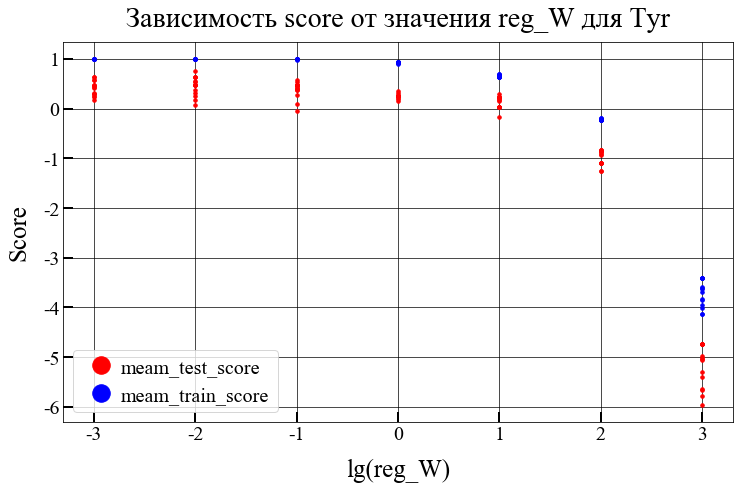

In [121]:
mpl.rc('font',family='Times New Roman')
fig, axs = plt.subplots(figsize=(12, 7))
axs.plot(xlab2,test,".",color="red",ms=7,label="meam_test_score")
axs.plot(xlab2,train,".",color="blue",ms=7,label="meam_train_score")
axs.set_ylabel('Score',  fontsize=25,labelpad=12)
axs.grid(color="black",linewidth=0.7)
axs.set_xlabel("lg(reg_W)",  fontsize=25,labelpad=15)
axs.set_title("Зависимость score от значения reg_W для Tyr", fontsize=28,loc="center" ,pad=15)
axs.tick_params(which='major', length=10, width=2)
axs.set_xticklabels(xlab6, fontsize=20)
axs.set_yticklabels(yy, fontsize=20)
axs.get_xaxis().set_tick_params(direction='in')
axs.get_yaxis().set_tick_params(direction='in')
axs.legend(fontsize=20, markerscale=5,handletextpad=0)

plt.savefig('Зависимость ошибки от параметров для Kruskal_Tyr.png', format='png', dpi=1024)
plt.show();

In [ ]:
axs.set_xticklabels(xlab, fontsize=20)

In [ ]:
axs.set_xticklabels(xlab6, fontsize=20)
axs.set_yticklabels(yy, fontsize=20)

### Строим графики предикт референс новые

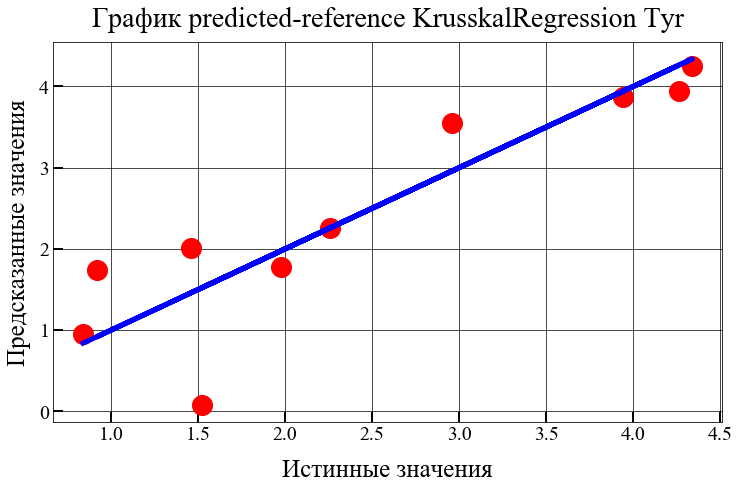

In [129]:
mpl.rc('font',family='Times New Roman')
fig, axs = plt.subplots(figsize=(12, 7))
axs.plot(y_test.iloc[:,1],predictors,".",color="red",ms=40)
axs.plot(y_test.iloc[:,1],y_test.iloc[:,1],color="blue",lw=5)
axs.set_ylabel("Предсказанные значения" , fontsize=25,labelpad=8)
axs.grid(color="black",linewidth=0.7)
axs.set_xlabel("Истинные значения",  fontsize=25,labelpad=15)
axs.set_title("График predicted-reference KrusskalRegression Tyr", fontsize=28,loc="center" ,pad=15)
axs.tick_params(which='major', length=10, width=2)
axs.set_xticklabels(xlab6, fontsize=20)
axs.set_yticklabels(yy, fontsize=20)
axs.get_xaxis().set_tick_params(direction='in')
axs.get_yaxis().set_tick_params(direction='in')
plt.savefig('График predicted-reference krusskal Tyr.png', format='png', dpi=1024)
plt.show();

In [124]:
xlab6=np.arange(0.5,5.5,0.5)

In [125]:
yy=np.arange(-1,6,1)

In [ ]:
axs.set_xticklabels(xlab6, fontsize=20)
axs.set_yticklabels(yy, fontsize=20)

In [35]:
predictors

array([3.71558649, 4.11922293, 2.90014398, 2.17650122, 2.57608838,
       2.71275246, 1.03353344, 3.10845509, 1.84088127, 2.68049709])

# Предыдущие наработки

In [1]:
gridCought.best_estimator_

NameError: name 'gridCought' is not defined

In [38]:
gridCought.score(X_test, y_test.iloc[:,0])

0.7036271555621243

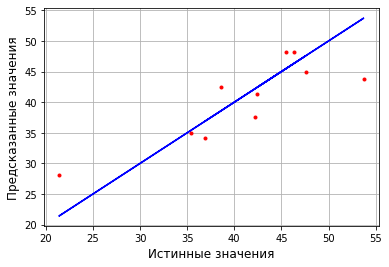

In [39]:
plt.plot(y_test.iloc[:,0],y_test.iloc[:,0],color="blue")
plt.plot(y_test.iloc[:,0],predictors,".",color="red")
plt.xlabel("Истинные значения",fontsize=12)
plt.ylabel("Предсказанные значения", fontsize=12)
plt.grid()
plt.show();

In [40]:
gridCought.scorer_

<function sklearn.metrics.scorer._passthrough_scorer(estimator, *args, **kwargs)>

In [41]:
gridCought.score

<bound method BaseSearchCV.score of GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=WrappedKruskalRegressor(n_iter_max=100, reg_W=1,
                                               tol=1e-06, weight_rank=1),
             iid='warn', n_jobs=None,
             param_grid={'n_iter_max': [300000],
                         'reg_W': array([1.e-06, 1.e-03, 1.e+00, 1.e+03]),
                         'tol': array([1.e-06, 1.e+00, 1.e+06]),
                         'weight_rank': range(1, 6)},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring=None, verbose=0)>

In [60]:
 gridCought.cv_results_

{'mean_fit_time': array([1.84724365e+02, 1.33805616e+02, 7.06979847e-01, 1.28220963e+00,
        2.97970438e+00, 1.67442322e-02, 6.54746056e-02, 1.34457350e-01,
        2.11561823e-01, 3.44115114e-01, 1.73454285e-02, 6.96840763e-02,
        1.32151461e-01, 2.83754110e-01, 3.44538546e-01, 2.84757390e+00,
        3.68797728e+01, 1.01356579e+03, 1.20347384e+02, 1.66959630e+03,
        2.14593410e-02, 5.55526733e-02, 9.77586746e-02, 1.65989923e-01,
        2.62022829e-01, 1.23339653e-02, 5.10396957e-02, 1.01077414e-01,
        1.66020155e-01, 2.60557079e-01, 6.08659060e+01, 2.72349798e+02,
        4.48102086e+02, 2.19639480e+02, 2.05719359e+02, 1.62418842e-02,
        6.38705254e-02, 1.20519781e-01, 1.97625637e-01, 3.64067650e-01,
        1.34350300e-02, 5.95587730e-02, 1.19217348e-01, 1.93515301e-01,
        3.04209852e-01, 6.39317134e+01, 5.40228164e+01, 3.28180871e+01,
        4.06642649e+01, 7.45927350e+01, 1.44412518e-02, 6.65765762e-02,
        1.35760689e-01, 2.16475201e-01, 3.10226

In [43]:
gridCought.cv_results_['mean_test_score']

array([-1.94725903, -1.20234605, -2.37135473, -2.34971526, -1.28876866,
       -0.56440616, -1.22393784, -1.42054168, -1.25347567, -1.57954612,
       -2.26944725, -0.50615847, -2.07489042, -1.02799115, -1.55341373,
       -1.69953442, -1.18511589, -0.70894033, -1.32380483, -0.58988544,
       -2.43341858, -0.83157111, -1.79958815, -1.35884643, -1.01983707,
       -2.76231602, -1.45865063, -1.37313893, -3.04093676, -0.93891769,
        0.23592157, -0.47413206, -0.44717629, -0.44620373, -0.44710572,
       -0.26337899, -1.00981646, -0.73992456, -0.54187129, -0.38447075,
        0.06204808, -0.63420008, -0.37747817, -1.1881647 , -0.5797442 ,
       -5.64052295, -5.64442679, -5.6405567 , -5.64050837, -5.64050528,
       -5.61944225, -5.78447084, -5.69142617, -5.88714542, -6.03647555,
       -6.12199827, -5.50324003, -5.8004489 , -5.85361174, -5.55129827])

In [44]:
cvres  = gridCought.cv_results_

In [45]:
gridCought.cv_results_['mean_test_score'][6]

-1.2239378435385617

In [46]:
min(gridCought.cv_results_['mean_test_score'])

-6.121998273597158

In [47]:
for mean_score,  params  in zip(cvres [ "mean_test_score" ], 
                                cvres [ "params" ]
                                ): 
    print (np.sqrt(mean_score**2) , params) 

1.94725902535621 {'n_iter_max': 300000, 'reg_W': 1e-06, 'tol': 1e-06, 'weight_rank': 1}
1.2023460524784542 {'n_iter_max': 300000, 'reg_W': 1e-06, 'tol': 1e-06, 'weight_rank': 2}
2.371354732753063 {'n_iter_max': 300000, 'reg_W': 1e-06, 'tol': 1e-06, 'weight_rank': 3}
2.349715257986199 {'n_iter_max': 300000, 'reg_W': 1e-06, 'tol': 1e-06, 'weight_rank': 4}
1.2887686631751205 {'n_iter_max': 300000, 'reg_W': 1e-06, 'tol': 1e-06, 'weight_rank': 5}
0.5644061556187371 {'n_iter_max': 300000, 'reg_W': 1e-06, 'tol': 1.0, 'weight_rank': 1}
1.2239378435385617 {'n_iter_max': 300000, 'reg_W': 1e-06, 'tol': 1.0, 'weight_rank': 2}
1.4205416841124738 {'n_iter_max': 300000, 'reg_W': 1e-06, 'tol': 1.0, 'weight_rank': 3}
1.2534756749570546 {'n_iter_max': 300000, 'reg_W': 1e-06, 'tol': 1.0, 'weight_rank': 4}
1.5795461204158883 {'n_iter_max': 300000, 'reg_W': 1e-06, 'tol': 1.0, 'weight_rank': 5}
2.2694472466629407 {'n_iter_max': 300000, 'reg_W': 1e-06, 'tol': 1000000.0, 'weight_rank': 1}
0.5061584667764485 {

In [48]:
score=[]
score_l=[]
parametr_reg_w=[]
my_error=[]

In [49]:
def f(x,y):
    my_error=[]
    for i in range(0,len(y)):
        my_error+=[(x[i]-y[i])**2]
    return my_error
my_error=f(np.array(y_test.iloc[:,0]),predictors)
print(my_error)

[7.850956241146074, 14.643503530972978, 97.84755979576325, 1.2699418109641938, 7.174238516316934, 3.705601479475632, 0.2091952710743093, 43.9737599086611, 20.99064700853719, 8.000135861234329]


In [50]:
for mean_score,  params  in zip (cvres [ "mean_test_score"],cvres [ "params" ] )  : 
    score+=[np.array(mean_score)**2]
    score_l+=[np.array((mean_score))]
    parametr_reg_w+=[params["reg_W"]]
print (score,"   ",parametr_reg_w) 


[3.791817711831217, 1.4456360299105218, 5.62332326855035, 5.521161793613149, 1.6609246671821871, 0.31855430850032207, 1.4980238448458247, 2.0179386763011036, 1.5712012677090437, 2.494965946520884, 5.150390805386002, 0.2561963934894851, 4.305170234864341, 1.0567658052358588, 2.4130942088948997, 2.8884172298324398, 1.4044996680536639, 0.5025963968107625, 1.7524592358836124, 0.3479648372542488, 5.921525999042486, 0.6915105064961977, 3.2385175177559034, 1.8464636293615941, 1.0400676410909038, 7.630389779862541, 2.1276616494438976, 1.8855105301314188, 9.247296377664615, 0.8815664337046574, 0.055658988224825304, 0.2248012138083978, 0.1999666367697437, 0.1990977665246284, 0.1999035205587089, 0.06936849421360114, 1.019729277773035, 0.5474883618516719, 0.2936244957893255, 0.14781776010688247, 0.0038499640442989065, 0.402209741504579, 0.14248976614500133, 1.4117353641731105, 0.3361033323232356, 31.815499182795282, 31.859553811762346, 31.815879891971047, 31.815334649187193, 31.81529985828484, 31.

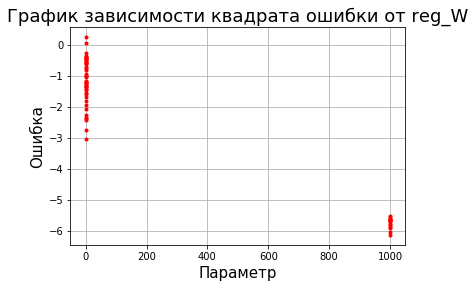

In [54]:
plt.plot(parametr_reg_w,score_l,".",color="red")
#plt.plot(parametr_reg_w,score_l,".",color="blue")
plt.grid()
plt.ylabel("Ошибка",fontsize=15)
plt.xlabel("Параметр",fontsize=15)
plt.title("График зависимости квадрата ошибки от reg_W",fontsize=18)
plt.show();

In [52]:
?file_obj.write(plt)

Object `file_obj.write(plt)` not found.
